In [1]:
include("fld.jl")
using PyPlot
using CSV

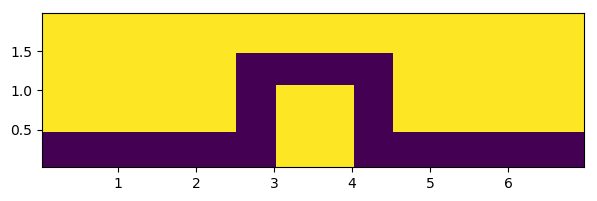

Running until time 5.0
Size of domain in Z is 7.0


PyObject <matplotlib.collections.QuadMesh object at 0x7f85582c0890>

In [2]:
tfinal = 5.
println("Running until time $(tfinal)")
Nr = 40
Nz = 140
Lz = 7.
println("Size of domain in Z is $(Lz)")
Lr = 2.
dr = Lr/Nr
dz = Lz/Nz

T = zeros(Nr*Nz)+1.0e-8

function sigma_func(t,T,Nr,Nz,Lr,Lz)
    sigma = zeros(Nr,Nz) + 10*20.0
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                sigma[i,j] = 0.01*20
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 2.75) <=0.25)
                sigma[i,j] = 0.01*20
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 4.25) <=0.25)
                sigma[i,j] = 0.01*20
            elseif ( (rcenter[i] + dr*0.5  < 1.5) & (rcenter[i] - dr*0.5  > 1.0)) & (abs(zcenter[j] - 3.5) <= 1.0)
                sigma[i,j] = 0.01*20
            end
        end
    end
    sigma
end

function Cv_func(t,T,Nr,Nz,Lr,Lz)
    cv = zeros(Nr,Nz) + 10*0.05
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                cv[i,j] = 0.01*0.05
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 2.75) <=0.25)
                cv[i,j] = 0.01*0.05
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 4.25) <=0.25)
                cv[i,j] = 0.01*0.05
            elseif ( (rcenter[i] + dr*0.5  < 1.5) & (rcenter[i] - dr*0.5  > 1.0)) & (abs(zcenter[j] - 3.5) <= 1.0)
                cv[i,j] = 0.01*0.05
            end
        end
    end
    cv                 
end
function D_func(t,T,Nr,Nz,Lr,Lz,Er_tmp,sigma) 
    #larsen n=2 flux limiter
    Er = reshape(T,Nr,Nz)
    idz = Nz/Lz
    idr = Nr/Lr
    D = zeros(Nr,Nz) 
    for i in 1:Nr
        for j in 1:Nz
            gradE = zeros(2)
            if (i > 1)
                gradE[1] += (Er[i,j]-Er[i-1,j])*idr*0.5
            end
            if (i < Nr)
                gradE[1] += (Er[i+1,j]-Er[i,j])*idr*0.5
            end
            if (j > 1)
                gradE[2] += (Er[i,j]-Er[i,j-1])*idz*0.5
            end
            if (j < Nz)
                gradE[2] += (Er[i,j+1]-Er[i,j])*idz*0.5
            end
            normGradE = sqrt(gradE[1]^2 + gradE[2]^2)/(Er[i,j] + 1e-12)
            
            D[i,j] = 1.0./sqrt( (3.0*sigma[i,j])^2 + normGradE^2)
        end
    end
    D
end

function EOS(t,T,Nr,Nz,Lr,Lz)
    T_tmp = reshape(T,Nr,Nz)
    E = zeros(Nr,Nz) + T_tmp*(10*0.05)
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 2.75) <=0.25)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.5) & (abs(zcenter[j] - 4.25) <=0.25)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            elseif ( (rcenter[i] + dr*0.5  < 1.5) & (rcenter[i] - dr*0.5  > 1.0)) & (abs(zcenter[j] - 3.5) <= 1.0)
                E[i,j] = T_tmp[i,j]*(0.01*0.05)
            end
        end
    end
    reshape(E,Nr*Nz)                 
end

function invEOS(t,T,Nr,Nz,Lr,Lz)
    E_tmp = reshape(T,Nr,Nz)
    T = zeros(Nr,Nz) + E_tmp/(10*0.05)
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*0.5) < 0.5) & (abs(zcenter[j] - 3.5) >=0.5)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.0) & (abs(zcenter[j] - 2.75) <=0.25)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            elseif ((rcenter[i] + dr*0.5) < 1.0) & (abs(zcenter[j] - 4.25) <=0.25)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            elseif ( (rcenter[i] + dr*0.5  < 1.5) & (rcenter[i] - dr*0.5  > 1.0)) & (abs(zcenter[j] - 3.5) <= 1.0)
                T[i,j] = E_tmp[i,j]/(0.01*0.05)
            end
        end
    end
    reshape(T,Nr*Nz)                 
end

function Q_func(t,T,Nr,Nz,Lr,Lz)
    Q = zeros(Nr,Nz)
end

rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
R,Z = meshgrid(rcenter,zcenter)
sig = sigma_func(0,T,Nr,Nz,Lr,Lz)
figure(figsize=(7,2))
pcolormesh(Z,R,(sig))

In [3]:
dt = 0.005
times, Er_t,T_t = time_dep_RT(tfinal,dt,T,zeros(Nr*Nz),D_func, sigma_func, Q_func,Cv_func,EOS,invEOS,
                      Nr, Nz, Lr, Lz, lower_z=a*.3^4, upper_z="vacuum", upper_r="refl",LOUD=-1,
    fname="runs/crooked_pipe$(Nr)_$(Nz)_$(dt).jld");

1001
Step 1001, t = 5.0


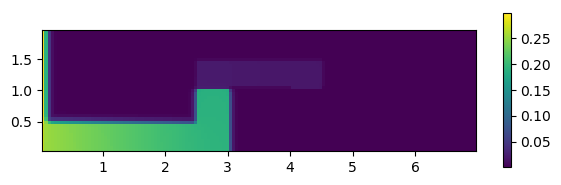

(0.025, 6.975, 0.025, 1.975)

In [4]:
Tr_plot = reshape((Er_t[:,size(times)[1]]/a).^.25,Nr,Nz)
figure(figsize=(7,2))
pcolormesh(Z,R,Tr_plot)
colorbar()
axis("scaled")

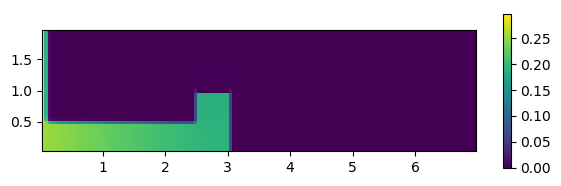

(0.025, 6.975, 0.025, 1.975)

In [5]:
T_plot = reshape(T_t[:,size(times)[1]],Nr,Nz)
figure(figsize=(7,2))
pcolormesh(Z,R,T_plot)
colorbar()
ylim(0,2)
xlim(0,7)
axis("scaled")